In [2]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.13.1'

## Load local Images

In [3]:
import pathlib

img_path = "/home/Data/CharactersTrimPad28/"
img_path = "/home/Data/ChineseNumbers/"
data_root = pathlib.Path(img_path)
print(data_root)

/home/Data/ChineseNumbers


In [4]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)
image_count

12607

In [5]:
all_image_paths[:10]

['/home/Data/ChineseNumbers/二/Han yi Cu yuan ti Font-Traditional Chinese ttf.png',
 '/home/Data/ChineseNumbers/二/JiaShang Liu Xing kai 5500 Font- Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Japan hengshan writing brush Font-Traditional Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Classic Cu hei Fontttf.png',
 '/home/Data/ChineseNumbers/二/Chinese New Year(DFGirl-dospy-fei) font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Han yi Fang die Fontttf.png',
 '/home/Data/ChineseNumbers/二/Classic Kong die hei Fontttf.png',
 '/home/Data/ChineseNumbers/二/Childhood amusement park Font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Snow World  Butterfly Font-Simplified Chinesettf.png',
 '/home/Data/ChineseNumbers/二/Hypocrite Youth v 20 Font-Simplified ChineseTTF.png']

## Determine the label

In [6]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['一', '七', '三', '九', '二', '五', '八', '六', '十', '四']

In [7]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'一': 0,
 '七': 1,
 '三': 2,
 '九': 3,
 '二': 4,
 '五': 5,
 '八': 6,
 '六': 7,
 '十': 8,
 '四': 9}

## Inspect the images and labels

In [27]:
import IPython.display as display
import random

random.shuffle(all_image_paths)
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
index_to_label = dict((index, label) for label,index in label_to_index.items())

for n in range(3):
  image_path = all_image_paths[n]
  display.display(display.Image(image_path))

  index = all_image_labels[n]
  label = index_to_label[index]
  print("label:", label, ", index:", index)
  print(image_path)

label: 十 , index: 8
/home/Data/ChineseNumbers/十/The footprints of stars Font-Simplified Chinese-Traditional Chinesettf.png


label: 七 , index: 1
/home/Data/ChineseNumbers/七/Naive broken Font-Traditional Chinese ttf.png


label: 九 , index: 3
/home/Data/ChineseNumbers/九/Childhood amusement park Font-Simplified Chinesettf.png


## Load and format the images

In [30]:
img_path = all_image_paths[0]
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=7, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1...


In [31]:
img_tensor = tf.image.decode_image(img_raw, channels=3)
print(img_tensor.shape)
print(img_tensor.dtype)


(28, 28, 3)
<dtype: 'uint8'>


In [32]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_tensor /= 255.0
print(img_tensor.shape)
print(img_tensor.dtype)

(28, 28, 3)
<dtype: 'float32'>


In [33]:
def preprocess_image(image):
  image = tf.image.decode_image(image, channels=3)
  image = tf.cast(image, tf.float32)
  image /= 255.0  # normalize to [0,1] range
  return image

In [34]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

/home/Data/ChineseNumbers/五/The Stars Cookies Chinese Font-Simplified Chinesettf.png
5 五


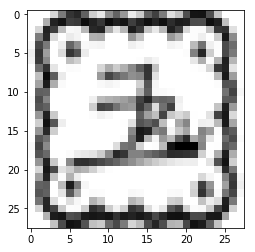

In [58]:
import matplotlib.pyplot as plt

index = random.randint(1, len(all_image_paths))
image_path = all_image_paths[index]
index = all_image_labels[index]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
print(image_path)
print(index, index_to_label[index])

## Build a `tf.data.Dataset`

In [59]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(path_ds)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)

<DatasetV1Adapter shapes: (), types: tf.string>
shape:  TensorShape([])
type:  <dtype: 'string'>


### A dataset of images

In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


### A dataset of (image, label) pairs

Method 1: zip two dataset

In [61]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [62]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<DatasetV1Adapter shapes: (<unknown>, ()), types: (tf.float32, tf.int64)>


Method 2: create from two arrays

In [63]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: (<unknown>, ()), types: (tf.float32, tf.int32)>

In [64]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (<unknown>, (?,)), types: (tf.float32, tf.int32)>

In [65]:
def preprocess_image(image):
  image = tf.image.decode_image(image, channels=3)
  image = tf.cast(image, tf.float32)
  image /= 255.0  # normalize to [0,1] range
  return image

In [66]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [67]:
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

In [68]:
image_count = len(all_image_paths)
NUM_EPOCHS = 3
BATCH_SIZE = 32

# Extract
# files = tf.data.Dataset.list_files("*.tfrecord")
# dataset = tf.data.TFRecordDataset(files)
path_label_ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))


# Transform
path_label_ds = path_label_ds.shuffle(buffer_size=image_count)
path_label_ds = path_label_ds.repeat(NUM_EPOCHS)
#path_label_ds = path_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count, count=NUM_EPOCHS))

#image_label_ds = path_label_ds.map(load_and_preprocess_from_path_label)
image_label_ds = path_label_ds.map(load_and_preprocess_from_path_label, num_parallel_calls=AUTOTUNE)
image_label_ds = path_label_ds.batch(BATCH_SIZE)
#image_label_ds = path_label_ds.apply(tf.data.experimental.map_and_batch(load_and_preprocess_from_path_label, BATCH_SIZE, num_parallel_calls=AUTOTUNE))

# Load
#image_label_ds = image_label_ds.cache(filename='./cache.tf-data')
#image_label_ds = image_label_ds.prefetch(buffer_size=AUTOTUNE) # Only on CPU
#image_label_ds = image_label_ds.apply(tf.data.experimental.prefetch_to_device(device="/gpu:0", buffer_size=AUTOTUNE)) # Must be final Dataset in input pipeline
image_batch, label_batch = next(iter(image_label_ds))

In [69]:
import time

steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
print(BATCH_SIZE, steps_per_epoch, 2*steps_per_epoch+1)

#def timeit(ds, batches=BATCH_SIZE):
def timeit(ds, batches=2*steps_per_epoch+1):

  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(batches+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(batches, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(end-overall_start))

32 394.0 789.0


In [40]:
timeit(image_label_ds)

.......................................................................................................................
nan batches: 0.25893449783325195 s
nan Images/s
Total time: 0.28349947929382324s


See more about [tf.data.experimental.shuffle_and_repeat](https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat)
```
tf.data.experimental.shuffle_and_repeat(
    buffer_size,
    count=None,
    seed=None
)
```

See more about [tf.data.experimental.map_and_batch](https://www.tensorflow.org/api_docs/python/tf/data/experimental/map_and_batch)
```
tf.data.experimental.map_and_batch(
    map_func,
    batch_size,
    num_parallel_batches=None,
    drop_remainder=False,
    num_parallel_calls=None
)
```

See more about [tf.data.experimental.prefetch_to_device](https://www.tensorflow.org/api_docs/python/tf/data/experimental/prefetch_to_device)
```
tf.data.experimental.prefetch_to_device(
    device,
    buffer_size=None
)
```

See more about [tf.data.Dataset.cache](https://www.tensorflow.org/tutorials/load_data/images#cache)
                                       
Use tf.data.Dataset.cache to easily cache calculations across epochs. This is especially performant if the dataq fits in memory
```
ds = image_label_ds.cache()
```

One disadvantage to using an in memory cache is that the cache must be rebuilt on each run, giving the same startup delay each time the dataset is started:
If the data doesn't fit in memory, use a cache file. 
The cache file also has the advantage that it can be used to quickly restart the dataset without rebuilding the cache. Note how much faster it is the second time:


```
ds = image_label_ds.cache(filename='./cache.tf-data')
```

When to use ds.cache()?

tf.data.Dataset.interleave vs. tf.data.experimental.parallel_interleave